In [1]:
import os, sys
from os import listdir
from os.path import isfile, isdir, join

In [10]:
import numpy as np
import pandas as pd
import cv2, imutils
from PIL import Image
import json, collections
import pickle as pkl
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
import time, shutil
import argparse, pathlib

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from scipy.spatial.transform import Rotation
from scipy.ndimage import uniform_filter1d, gaussian_filter1d, median_filter
from trimesh.visual import TextureVisuals
from typing import Dict, Iterable, Callable

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
device = torch.device('cuda:0') #use cpu if no gpu
# device = torch.device('cpu') 

import pytorch3d, librosa
from menpo import shape
from menpo.image import BooleanImage
from menpo3d.barycentric import barycentric_points_from_contained_points
from pytorch3d.io import load_objs_as_meshes, load_obj, load_ply, save_obj, save_ply
from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.renderer.mesh.rasterizer import Fragments
from pytorch3d.renderer.mesh.shader import ShaderBase, hard_rgb_blend, softmax_rgb_blend
from pytorch3d.renderer import (look_at_view_transform, FoVPerspectiveCameras, FoVOrthographicCameras,
                                PointLights, DirectionalLights, Materials, 
                                RasterizationSettings, PointsRasterizationSettings,
                                MeshRenderer, PointsRenderer,
                                MeshRasterizer, PointsRasterizer,
                                SoftPhongShader, HardPhongShader, SoftGouraudShader, HardGouraudShader,
                                Textures, TexturesUV, TexturesVertex,
                                AlphaCompositor, BlendParams)

ModuleNotFoundError: No module named 'pytorch3d'

In [4]:
SEED = 2334
torch.manual_seed(SEED)
np.random.seed(SEED)
plt.ion()

In [5]:
class dummy_shader(ShaderBase):
    def __init__(self, device, cameras, blend_params):
        super(dummy_shader, self).__init__(device, cameras, None, None, blend_params)
        
    def forward(self, fragments: Fragments, meshes: Meshes, **kwargs) -> torch.Tensor:
        cameras = super()._get_cameras(**kwargs)
        texels = meshes.sample_textures(fragments)
        blend_params = kwargs.get("blend_params", self.blend_params)
        images = hard_rgb_blend(texels, fragments, blend_params)
        # images = softmax_rgb_blend(texels, fragments, blend_params)
        return images

In [6]:
def save_meshes_as_objs(fp_list, mesh, save_textures = True):
    for idx, fp in enumerate(fp_list):
        verts = mesh.verts_padded()[idx]
        faces = mesh.faces_padded()[idx]
        if save_textures:
            if mesh.textures.isempty():
                raise Exception('Save untextured mesh with param save_textures=True')
            texture_map = mesh.textures.maps_padded()[idx]
            verts_uvs = mesh.textures.verts_uvs_padded()[idx]
            faces_uvs = mesh.textures.faces_uvs_padded()[idx]
            save_obj(fp, verts, faces, verts_uvs = verts_uvs, faces_uvs = faces_uvs, texture_map = texture_map)
        else:
            save_obj(fp, verts, faces)

In [7]:
def get_timestamp(ts):
    td = timedelta(seconds=ts)
    dt = datetime.strptime("00:00:00", "%H:%M:%S") + td
    return dt.strftime("%H:%M:%S.%f")

def get_framenum(ts, fps):
    dt = datetime.strptime(ts, "%H:%M:%S.%f")
    td = dt-datetime.strptime("00:00:00.000000", "%H:%M:%S.%f")
    return int(td.total_seconds()*fps)

In [8]:
sys.argv = ['code.py', 
            '--video_path', 'D:/Datasets/JALI/360/360 Speaking Video Cafe scene.mp4', #'path/to/360_video.mp4',
            '--gaze_data_path', 'path/to/gaze_data.csv',
            '--save_path', 'D:/Datasets/JALI/360_renders/360 Speaking Video Cafe scene.mp4', #'path/to/save_file.mp4'
            ]

parser = argparse.ArgumentParser()
parser.add_argument('--video_path', type=str)
parser.add_argument('--gaze_data_path', type=str)
parser.add_argument('--save_path', type=str)
parser.add_argument('--csv_seperator', type=str, default=',', required=False)
parser.add_argument('--square_resolution', type=int, default=512, required=False)
hyperparams = parser.parse_args()
print(hyperparams)

Namespace(video_path='D:/Datasets/JALI/360/360 Speaking Video Cafe scene.mp4', gaze_data_path='path/to/gaze_data.csv', save_path='D:/Datasets/JALI/360_renders/360 Speaking Video Cafe scene.mp4', csv_seperator=',', square_resolution=512)


In [9]:
raster_settings = RasterizationSettings(
    image_size=1024, #512, reduce for speedup 
    # blur_radius=1e-6, 
    blur_radius=0, 
    faces_per_pixel=1,  
    bin_size=None
)
lights = PointLights(device=device, location=[[1.0, 1.0, 1.0]], ambient_color=[[0.5, 0.5, 0.5]])
blend_params = BlendParams(sigma=1e-4, gamma=1e-4, background_color=(0.0, 0.0, 0.0))

In [10]:
assert isfile(hyperparams.video_path)
video_dir = str(pathlib.Path(hyperparams.video_path).parent.absolute())
video_names = [os.path.basename(hyperparams.video_path)]
video_names.sort()
print(video_names)

save_dir = str(pathlib.Path(hyperparams.save_path).parent.absolute())
assert isdir(save_dir)
if not isdir(save_dir):
    os.mkdir(save_dir)

['360 Speaking Video Cafe scene.mp4']


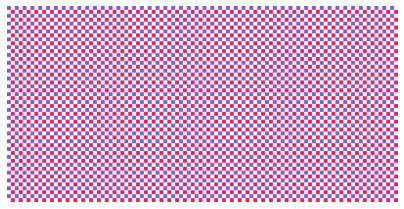

torch.Size([7938, 3]) torch.Size([15872, 3])
torch.Size([8249, 2]) torch.Size([15872, 3])


In [11]:
vr_sphere_obj_path = './VRSphereUV.obj'
meshes = load_objs_as_meshes([vr_sphere_obj_path], device=device)
plt.figure(figsize=(7,7))
texture_image=meshes.textures.maps_padded()
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.axis("off")
plt.show()

verts = meshes.verts_padded()
faces = meshes.faces_padded()
verts_uvs = meshes.textures.verts_uvs_padded()
faces_uvs = meshes.textures.faces_uvs_padded()
verts_uvs[0, :, 0] = 1.-verts_uvs[0, :, 0]
print(verts[0].shape, faces[0].shape)
print(verts_uvs[0].shape, faces_uvs[0].shape)

In [ ]:
gaze_df = pd.read_csv(hyperparams.gaze_data_path, sep=',', header=None).to_numpy()
gaze_df = gaze_df.astype(np.float32)
print(gaze_df.shape)

In [ ]:
exit_flag = False
fixed_height = hyperparams.square_resolution
camera_offsets = (0, 0, 0)
# gaze_df = np.zeros((1, 2), dtype=np.float32)+30.

for vid_idx in range(len(video_names)):
    vid_name = video_names[vid_idx]
    vid_prefix = vid_name.split('.')[0]
    vid_path = join(video_dir, vid_name)
    
    cap = cv2.VideoCapture(vid_path)
    width, height = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps, frame_count = cap.get(cv2.CAP_PROP_FPS), int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(vid_prefix)
    print('RES:{}x{}|FPS:{}'.format(width, height, fps))

    writer = cv2.VideoWriter(hyperparams.save_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'),
                             fps, (fixed_height, fixed_height))
    assert (gaze_df.ndim==2)
    if gaze_df.shape[0]>=frame_count:
        gaze_df = gaze_df[:frame_count, ...]
    else:
        gaze_df = np.pad(gaze_df, ((0, frame_count-gaze_df.shape[0]), (0, 0)), mode='edge')

    for frame_num in tqdm(range(frame_count)):
        ret, frame = cap.read()
        if not ret:
            break

        frame_copy = frame.copy()
        frame_resized = imutils.resize(frame, height=720)
        frame_bgr = frame_copy[:, :, ::-1].copy()
        frame_bgr = imutils.resize(frame_bgr, height=1000)
        
        with torch.no_grad():
            frame_bgr_tensor = torch.from_numpy(frame_bgr.astype(np.float32)/255.).to(device)
            mesh_textures = TexturesUV([frame_bgr_tensor], faces_uvs=faces_uvs, verts_uvs=verts_uvs)
            torch_meshes = Meshes(verts, faces, mesh_textures)
            
            R, T = look_at_view_transform(1e-5, 0.-gaze_df[frame_num, 0], -90.-gaze_df[frame_num, 1], at=((0., 0., 0.),), degrees=True)
            cameras = FoVPerspectiveCameras(znear=0.1 ,device=device, R=R, T=T, fov=70.0)
            # print(R,T)

            unshader = dummy_shader(
                        device=device,
                        cameras=cameras,
                        blend_params=blend_params
            )
            rasterizer = MeshRasterizer(cameras=cameras, raster_settings=raster_settings)
            renderer = MeshRenderer(rasterizer=rasterizer, shader=unshader)
            image_tensor = renderer(torch_meshes)
            image_render = np.clip(image_tensor[0, ..., :3].cpu().numpy()*255., 0., 255.).astype(np.uint8)
            frame_copy = imutils.resize(image_render, height=fixed_height)

        disp_frame = frame_copy[..., ::-1].copy()
        writer.write(disp_frame)
        cv2.imshow('Video', disp_frame)
        ch = cv2.waitKey(1)
        if ch<0:
            continue
        elif chr(ch)=='x':
            exit_flag = True
            break
        elif chr(ch)=='n':
            break
    writer.release()
    if exit_flag:
        break
cv2.destroyAllWindows()

cmd = 'ffmpeg -i "{}" -i "{}" -map 0:v -map 1:a -c:v libx264 -c:a copy -strict -2 "{}"'.format(hyperparams.save_path, 
                                                                                             hyperparams.video_path, 
                                                                                             join(save_dir, 'temp.mp4'))
os.system(cmd)
shutil.copy(join(save_dir, 'temp.mp4'), hyperparams.save_path)
os.remove(hyperparams.save_path)